In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/aayushmishra1512/twitchdata

https://www.kaggle.com/girlazo/top-8800-twitch-streamers

In [3]:
df = pd.read_csv('data/twitchdata-update.csv')
df_extended = pd.read_csv('data/TwitchDataSet.csv')
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Channel               1000 non-null   object
 1   Watch time(Minutes)   1000 non-null   int64 
 2   Stream time(minutes)  1000 non-null   int64 
 3   Peak viewers          1000 non-null   int64 
 4   Average viewers       1000 non-null   int64 
 5   Followers             1000 non-null   int64 
 6   Followers gained      1000 non-null   int64 
 7   Views gained          1000 non-null   int64 
 8   Partnered             1000 non-null   bool  
 9   Mature                1000 non-null   bool  
 10  Language              1000 non-null   object
dtypes: bool(2), int64(7), object(2)
memory usage: 72.4+ KB


In [5]:
df.isnull().sum()

Channel                 0
Watch time(Minutes)     0
Stream time(minutes)    0
Peak viewers            0
Average viewers         0
Followers               0
Followers gained        0
Views gained            0
Partnered               0
Mature                  0
Language                0
dtype: int64

In [6]:
df.dtypes

Channel                 object
Watch time(Minutes)      int64
Stream time(minutes)     int64
Peak viewers             int64
Average viewers          int64
Followers                int64
Followers gained         int64
Views gained             int64
Partnered                 bool
Mature                    bool
Language                object
dtype: object

In [7]:
df.describe()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,4.184279e+08,120515.160000,37065.051000,4781.040000,5.700541e+05,2.055185e+05,1.166817e+07
std,5.496355e+08,85376.201364,60314.307686,8453.684965,8.044134e+05,3.399137e+05,2.490572e+07
min,1.221928e+08,3465.000000,496.000000,235.000000,3.660000e+03,-1.577200e+04,1.757880e+05
25%,1.631899e+08,73758.750000,9113.750000,1457.750000,1.705462e+05,4.375825e+04,3.880602e+06
50%,2.349908e+08,108240.000000,16676.000000,2425.000000,3.180630e+05,9.835200e+04,6.456324e+06
75%,4.337399e+08,141843.750000,37569.750000,4786.250000,6.243322e+05,2.361308e+05,1.219676e+07
max,6.196162e+09,521445.000000,639375.000000,147643.000000,8.938903e+06,3.966525e+06,6.701375e+08


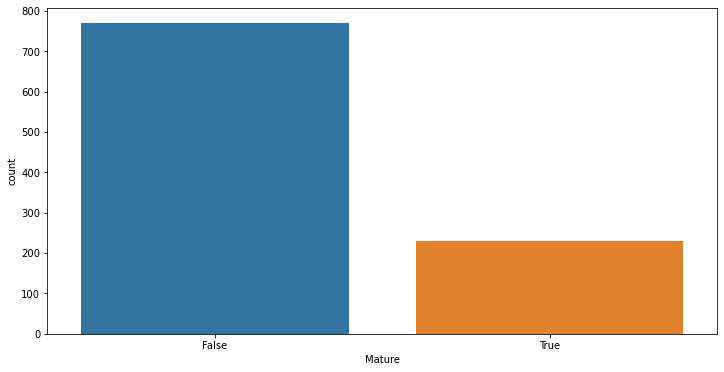

In [8]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(x="Mature", data=df,order=df['Mature'].value_counts().index)

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29378 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52899 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48709 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52852 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20820 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50573 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 27578 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26775 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46965 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44204 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 55148 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44404 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

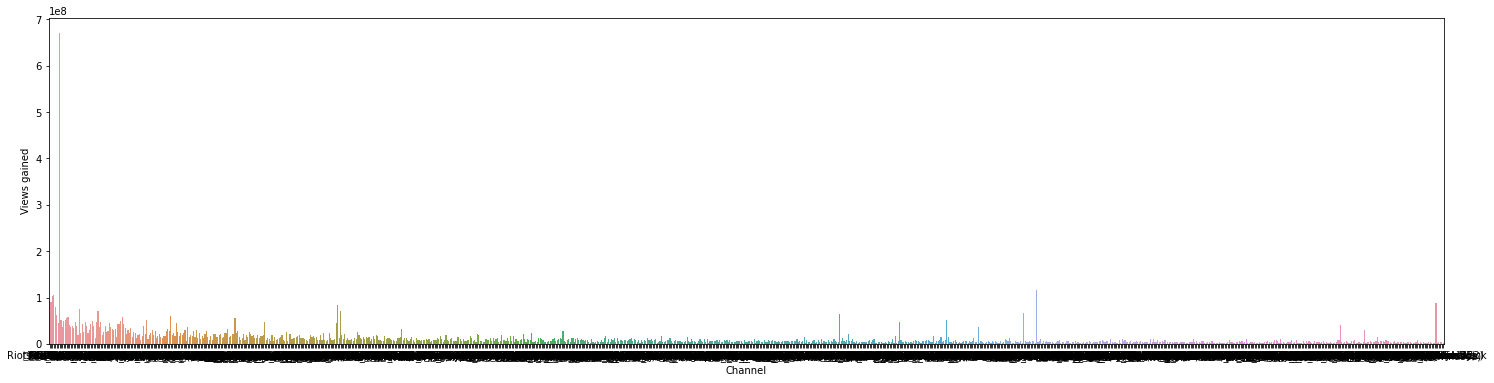

In [9]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == True]['Channel'], y=df[df.Partnered == True]['Views gained'],order=df[df.Partnered == True]['Channel'])
plt.show()

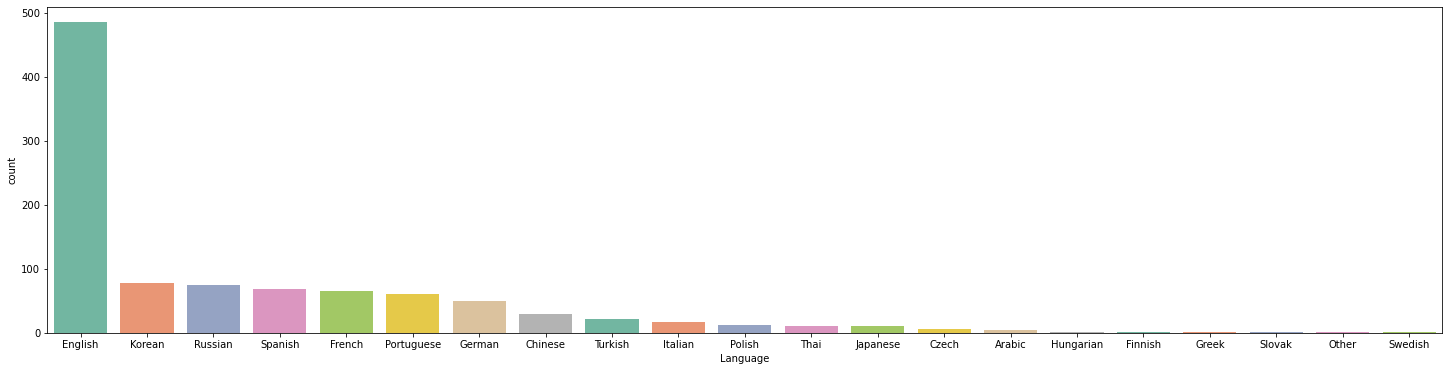

In [10]:
plt.figure(figsize=(25, 6))
plot = sns.countplot(x="Language", data=df,order=df['Language'].value_counts().index, palette="Set2")

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packa

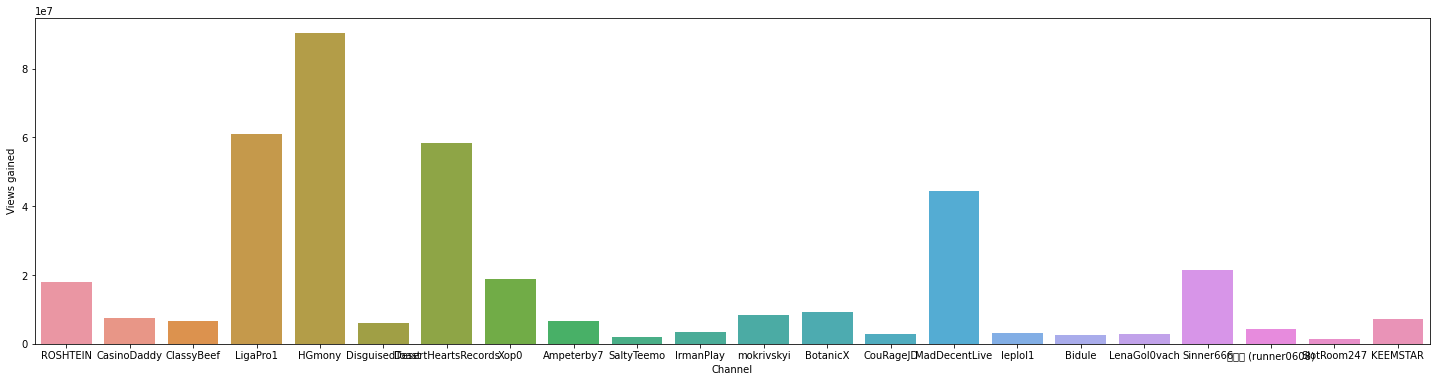

In [11]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == False]['Channel'] , y=df[df.Partnered == False]['Views gained'],order=df[df.Partnered == False]['Channel'])
plt.show()

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50573 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26775 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46965 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36386 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 34407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54952 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50864 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50753 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44403 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 27954 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32113 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31070 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46616 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44204 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 55148 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44404 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

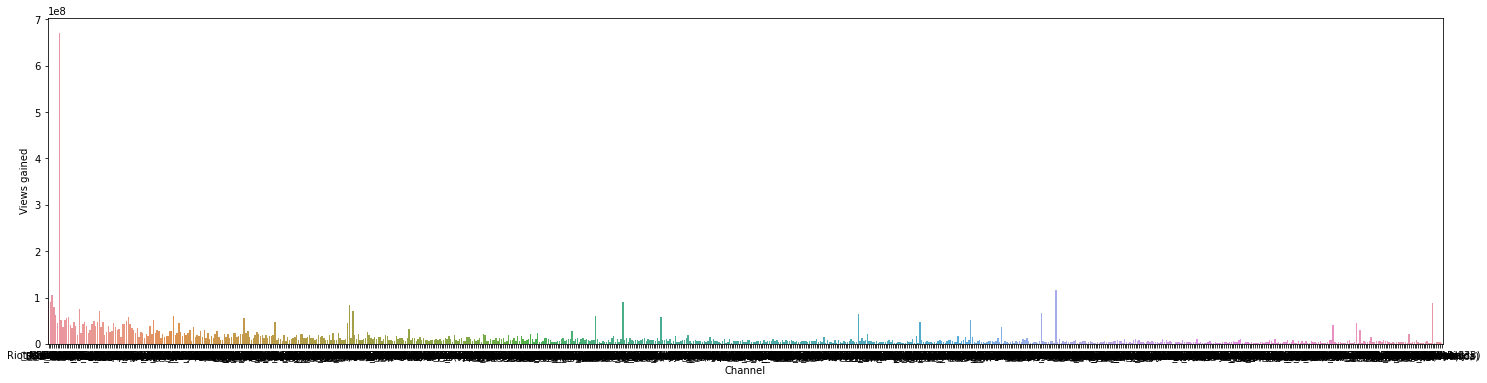

In [12]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == False]['Channel'] , y=df[df.Mature == False]['Views gained'],order=df[df.Mature == False]['Channel'])
plt.show()

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 34662 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 33655 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22812 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35997 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

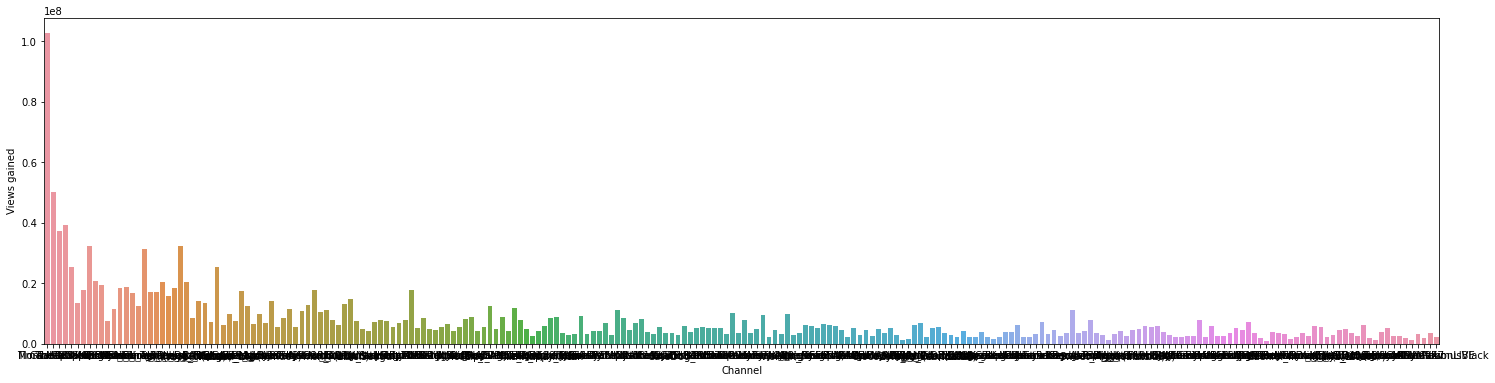

In [13]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == True]['Channel'], y=df[df.Mature == True]['Views gained'],order=df[df.Mature == True]['Channel'])
plt.show()

In [14]:
df_extended.head()

,profile picture,top count,screen name,watch time,stream time,peak viewers,average viewers,followers,followers gained,views gained,partnered,mature,language,completa name,first category,second category,third category
0,https://static-cdn.jtvnw.net/jtv_user_pictures...,1,xQcOW,7333609065,215670,222720,32913,3691010,2051895,109735389,True,False,English,xQcOW,Just Chatting,Among Us,Overwatch
1,https://static-cdn.jtvnw.net/jtv_user_pictures...,2,Gaules,6314532585,515595,387315,12254,1966465,1141123,112807468,True,True,Portuguese,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
2,https://static-cdn.jtvnw.net/jtv_user_pictures...,3,summit1g,6235007490,216000,310998,25931,5374710,1402547,91501875,True,False,English,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
3,https://static-cdn.jtvnw.net/jtv_user_pictures...,4,ESL_CSGO,4764929775,517965,300575,9249,4195657,870484,126008641,True,False,English,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,https://static-cdn.jtvnw.net/jtv_user_pictures...,5,NICKMERCS,3853252845,131880,163241,29183,4415637,1337535,49164651,True,False,English,NICKMERCS,Call Of Duty: Modern Warfare,Fortnite,Halo: The Master Chief Collection


In [15]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile picture   8800 non-null   object
 1   top count         8800 non-null   int64 
 2   screen name       8800 non-null   object
 3   watch time        8800 non-null   int64 
 4   stream time       8800 non-null   int64 
 5   peak viewers      8800 non-null   int64 
 6   average viewers   8800 non-null   int64 
 7   followers         8800 non-null   int64 
 8   followers gained  8800 non-null   int64 
 9   views gained      8800 non-null   int64 
 10  partnered         8800 non-null   bool  
 11  mature            8800 non-null   bool  
 12  language          8799 non-null   object
 13  completa name     8800 non-null   object
 14  first category    8795 non-null   object
 15  second category   8390 non-null   object
 16  third category    8009 non-null   object
dtypes: bool(2), in

In [16]:
df_extended.isnull().sum()

profile picture       0
top count             0
screen name           0
watch time            0
stream time           0
peak viewers          0
average viewers       0
followers             0
followers gained      0
views gained          0
partnered             0
mature                0
language              1
completa name         0
first category        5
second category     410
third category      791
dtype: int64

In [17]:
df_extended.dtypes

profile picture     object
top count            int64
screen name         object
watch time           int64
stream time          int64
peak viewers         int64
average viewers      int64
followers            int64
followers gained     int64
views gained         int64
partnered             bool
mature                bool
language            object
completa name       object
first category      object
second category     object
third category      object
dtype: object

## Data Cleaning

Merging the data sets together and drop duplicates

In [19]:
df_extended.rename(columns={'screen name':'Channel', 'watch time': 'Watch time(Minutes)', 'stream time': 'Stream time(minutes)', 'peak viewers': 'Peak viewers', 'average viewers': 'Average viewers', 'followers': 'Followers', 'followers gained': 'Followers gained', 'views gained': 'Views gained', 'partnered': 'Partnered', 'mature': 'Mature', 'language': 'Language'}, inplace = True)

In [21]:
df_extended.head()

,profile picture,top count,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language,completa name,first category,second category,third category
0,https://static-cdn.jtvnw.net/jtv_user_pictures...,1,xQcOW,7333609065,215670,222720,32913,3691010,2051895,109735389,True,False,English,xQcOW,Just Chatting,Among Us,Overwatch
1,https://static-cdn.jtvnw.net/jtv_user_pictures...,2,Gaules,6314532585,515595,387315,12254,1966465,1141123,112807468,True,True,Portuguese,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
2,https://static-cdn.jtvnw.net/jtv_user_pictures...,3,summit1g,6235007490,216000,310998,25931,5374710,1402547,91501875,True,False,English,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
3,https://static-cdn.jtvnw.net/jtv_user_pictures...,4,ESL_CSGO,4764929775,517965,300575,9249,4195657,870484,126008641,True,False,English,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,https://static-cdn.jtvnw.net/jtv_user_pictures...,5,NICKMERCS,3853252845,131880,163241,29183,4415637,1337535,49164651,True,False,English,NICKMERCS,Call Of Duty: Modern Warfare,Fortnite,Halo: The Master Chief Collection


In [54]:
#Merging Datasets on the Crash_Record_ID Column
df_merge = pd.merge(df, df_extended, on=['Channel',
                                        'Partnered','Mature', 'Language']).reset_index()

#dropping duplicates(checks Channel for uniqueness)
df_dropped= df_merge.drop_duplicates(subset=['Channel'], keep='first')

In [55]:
df_dropped.head()

,index,Channel,Watch time(Minutes)_x,Stream time(minutes)_x,Peak viewers_x,Average viewers_x,Followers_x,Followers gained_x,Views gained_x,Partnered,...,Stream time(minutes)_y,Peak viewers_y,Average viewers_y,Followers_y,Followers gained_y,Views gained_y,completa name,first category,second category,third category
0,0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,...,215670,222720,32913,3691010,2051895,109735389,xQcOW,Just Chatting,Among Us,Overwatch
1,1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,...,216000,310998,25931,5374710,1402547,91501875,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
2,2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,...,515595,387315,12254,1966465,1141123,112807468,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
3,3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,...,517965,300575,9249,4195657,870484,126008641,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,...,130680,190173,25269,9184421,2023733,70427346,Tfue,Fortnite,Call Of Duty: Modern Warfare,Among Us


In [57]:
df_dropped.size

23900

In [59]:
df_extended.size

149600

In [60]:
df.size

11000

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

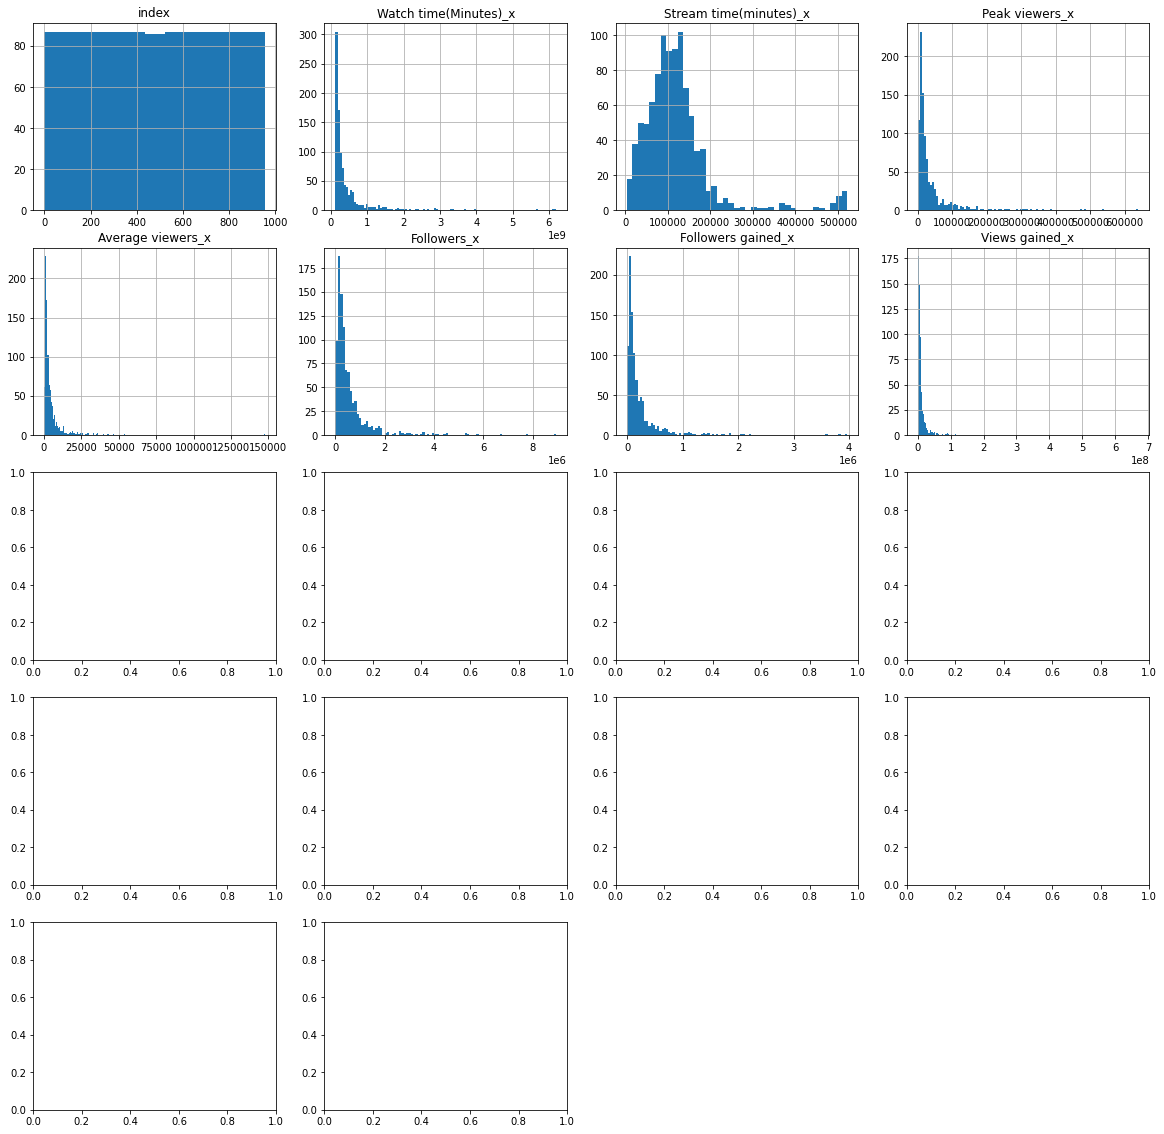

In [61]:
df_dropped.hist(figsize=(20,20), bins='auto');